# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

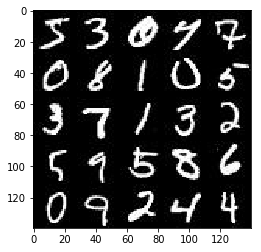

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

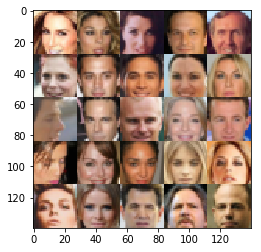

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Anaconda3\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Anaconda3\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Anaconda3\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Anaconda3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "C:\\Anaconda3\\lib\\site-packages\\zmq\\eventloop\\ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "C:\\Anaconda3\\lib\\site-pac

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        layer = tf.layers.conv2d(images, 64, 3, 2, 'same', use_bias=False)
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha * layer, layer)
        # 14 x 14 x 64

        layer = tf.layers.conv2d(layer, 128, 3, 2, 'same', use_bias=False)
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha * layer, layer)
        # 7 x 7 x 128

        layer = tf.layers.conv2d(layer, 256, 3, 2, 'same', use_bias=False)
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha * layer, layer)
        # 4 x 4 x 256
        
        layer = tf.reshape(layer, (-1, 4 * 4 * 256))
        
        logits = tf.layers.dense(layer, 1)
        out = tf.sigmoid(logits)

    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train)):

        layer = tf.layers.dense(z, 7 * 7 * 512, use_bias=False)
        
        layer = tf.reshape(layer, (-1, 7, 7, 512))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(alpha * layer, layer)
        # 7 x 7 x 1024

        layer = tf.layers.conv2d_transpose(layer, 256, 5, 2, 'SAME')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(alpha * layer, layer)
        # 14 x 14 x 512

        layer = tf.layers.conv2d_transpose(layer, 128, 5, 2, 'SAME')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(alpha * layer, layer)
        # 28 x 28 x 256

        layer = tf.layers.conv2d_transpose(layer, out_channel_dim, 5, 1, 'SAME')
        # 28 x 28 x 3

        out = tf.tanh(layer) / 2.0
            
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, True, alpha)
    d_logits_real, d_model_real = discriminator(input_real, False, alpha)
    d_logits_fake, d_model_fake = discriminator(g_model, True, alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=(tf.ones_like(d_model_real) * 0.9)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = []
    g_vars = []
    
    for var in t_vars:
        if var.name.startswith('discriminator'):
            d_vars.append(var)
        elif var.name.startswith('generator'):
            g_vars.append(var)

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    img_channels = 3 if data_image_mode == 'RGB' else 1
    _, image_width, image_height, colors = data_shape
    
    input_real, input_z, input_learning_rate = model_inputs(image_width, image_height, img_channels, z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, img_channels, 0.2)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, input_learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Step {:5}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, img_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step    10... Discriminator Loss: 2.4995... Generator Loss: 0.1757
Epoch 1/2... Step    20... Discriminator Loss: 0.7517... Generator Loss: 1.4840
Epoch 1/2... Step    30... Discriminator Loss: 1.1731... Generator Loss: 0.7784
Epoch 1/2... Step    40... Discriminator Loss: 0.9437... Generator Loss: 1.0974
Epoch 1/2... Step    50... Discriminator Loss: 0.7764... Generator Loss: 1.6812
Epoch 1/2... Step    60... Discriminator Loss: 1.4375... Generator Loss: 1.1258
Epoch 1/2... Step    70... Discriminator Loss: 1.3837... Generator Loss: 1.6353
Epoch 1/2... Step    80... Discriminator Loss: 1.6283... Generator Loss: 0.4571
Epoch 1/2... Step    90... Discriminator Loss: 1.5018... Generator Loss: 0.5308
Epoch 1/2... Step   100... Discriminator Loss: 1.2765... Generator Loss: 0.6795


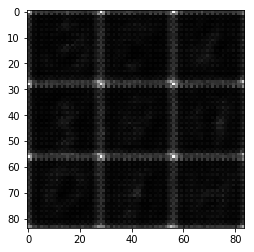

Epoch 1/2... Step   110... Discriminator Loss: 1.5229... Generator Loss: 0.4552
Epoch 1/2... Step   120... Discriminator Loss: 1.5520... Generator Loss: 0.4773
Epoch 1/2... Step   130... Discriminator Loss: 1.2748... Generator Loss: 0.6659
Epoch 1/2... Step   140... Discriminator Loss: 1.4188... Generator Loss: 1.2598
Epoch 1/2... Step   150... Discriminator Loss: 1.2560... Generator Loss: 1.0547
Epoch 1/2... Step   160... Discriminator Loss: 1.2390... Generator Loss: 1.1830
Epoch 1/2... Step   170... Discriminator Loss: 1.2933... Generator Loss: 1.1123
Epoch 1/2... Step   180... Discriminator Loss: 1.1771... Generator Loss: 1.2049
Epoch 1/2... Step   190... Discriminator Loss: 1.1590... Generator Loss: 1.0975
Epoch 1/2... Step   200... Discriminator Loss: 1.5689... Generator Loss: 0.4009


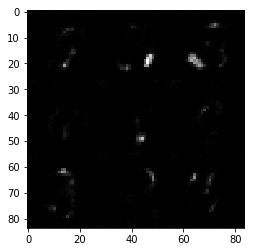

Epoch 1/2... Step   210... Discriminator Loss: 1.1618... Generator Loss: 0.8292
Epoch 1/2... Step   220... Discriminator Loss: 1.0834... Generator Loss: 1.0422
Epoch 1/2... Step   230... Discriminator Loss: 1.2084... Generator Loss: 1.2318
Epoch 1/2... Step   240... Discriminator Loss: 1.0923... Generator Loss: 1.0184
Epoch 1/2... Step   250... Discriminator Loss: 1.1649... Generator Loss: 1.2648
Epoch 1/2... Step   260... Discriminator Loss: 1.1090... Generator Loss: 1.4017
Epoch 1/2... Step   270... Discriminator Loss: 1.0698... Generator Loss: 1.4958
Epoch 1/2... Step   280... Discriminator Loss: 1.1530... Generator Loss: 1.5773
Epoch 1/2... Step   290... Discriminator Loss: 1.1548... Generator Loss: 1.3714
Epoch 1/2... Step   300... Discriminator Loss: 1.1899... Generator Loss: 0.6469


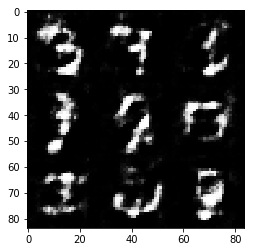

Epoch 1/2... Step   310... Discriminator Loss: 1.1695... Generator Loss: 0.7856
Epoch 1/2... Step   320... Discriminator Loss: 1.0970... Generator Loss: 0.7532
Epoch 1/2... Step   330... Discriminator Loss: 1.4566... Generator Loss: 0.4769
Epoch 1/2... Step   340... Discriminator Loss: 1.1140... Generator Loss: 0.9971
Epoch 1/2... Step   350... Discriminator Loss: 1.2153... Generator Loss: 0.6358
Epoch 1/2... Step   360... Discriminator Loss: 1.3890... Generator Loss: 0.4890
Epoch 1/2... Step   370... Discriminator Loss: 1.0554... Generator Loss: 0.9242
Epoch 1/2... Step   380... Discriminator Loss: 1.2485... Generator Loss: 0.5667
Epoch 1/2... Step   390... Discriminator Loss: 1.2690... Generator Loss: 0.5773
Epoch 1/2... Step   400... Discriminator Loss: 1.5198... Generator Loss: 0.4009


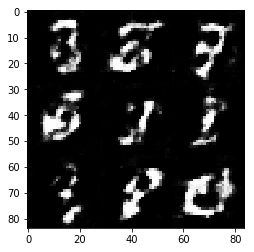

Epoch 1/2... Step   410... Discriminator Loss: 1.0649... Generator Loss: 0.7661
Epoch 1/2... Step   420... Discriminator Loss: 1.0692... Generator Loss: 0.7727
Epoch 1/2... Step   430... Discriminator Loss: 1.2483... Generator Loss: 0.5893
Epoch 1/2... Step   440... Discriminator Loss: 1.1331... Generator Loss: 0.7119
Epoch 1/2... Step   450... Discriminator Loss: 0.9937... Generator Loss: 1.2655
Epoch 1/2... Step   460... Discriminator Loss: 1.1266... Generator Loss: 1.7285
Epoch 1/2... Step   470... Discriminator Loss: 1.0267... Generator Loss: 1.3904
Epoch 1/2... Step   480... Discriminator Loss: 1.1587... Generator Loss: 1.6607
Epoch 1/2... Step   490... Discriminator Loss: 1.0848... Generator Loss: 1.1257
Epoch 1/2... Step   500... Discriminator Loss: 1.2943... Generator Loss: 1.4695


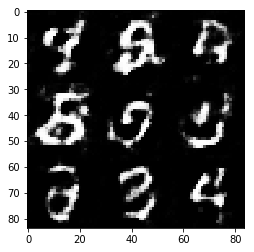

Epoch 1/2... Step   510... Discriminator Loss: 1.2056... Generator Loss: 1.6987
Epoch 1/2... Step   520... Discriminator Loss: 1.1495... Generator Loss: 0.7726
Epoch 1/2... Step   530... Discriminator Loss: 1.0472... Generator Loss: 1.1069
Epoch 1/2... Step   540... Discriminator Loss: 1.1247... Generator Loss: 1.3251
Epoch 1/2... Step   550... Discriminator Loss: 1.4589... Generator Loss: 1.3574
Epoch 1/2... Step   560... Discriminator Loss: 1.2046... Generator Loss: 0.8673
Epoch 1/2... Step   570... Discriminator Loss: 1.1909... Generator Loss: 1.0741
Epoch 1/2... Step   580... Discriminator Loss: 1.3290... Generator Loss: 1.1927
Epoch 1/2... Step   590... Discriminator Loss: 1.3695... Generator Loss: 0.5096
Epoch 1/2... Step   600... Discriminator Loss: 1.3149... Generator Loss: 0.5376


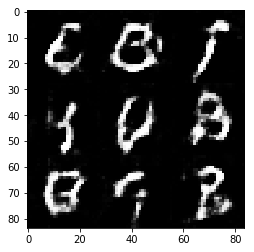

Epoch 2/2... Step   610... Discriminator Loss: 1.5516... Generator Loss: 0.3943
Epoch 2/2... Step   620... Discriminator Loss: 1.4592... Generator Loss: 0.4886
Epoch 2/2... Step   630... Discriminator Loss: 1.3920... Generator Loss: 0.4909
Epoch 2/2... Step   640... Discriminator Loss: 1.5121... Generator Loss: 0.4321
Epoch 2/2... Step   650... Discriminator Loss: 1.2700... Generator Loss: 0.6597
Epoch 2/2... Step   660... Discriminator Loss: 1.1440... Generator Loss: 1.1825
Epoch 2/2... Step   670... Discriminator Loss: 1.1870... Generator Loss: 1.0348
Epoch 2/2... Step   680... Discriminator Loss: 1.2221... Generator Loss: 0.8472
Epoch 2/2... Step   690... Discriminator Loss: 1.2692... Generator Loss: 1.4948
Epoch 2/2... Step   700... Discriminator Loss: 1.1470... Generator Loss: 1.0456


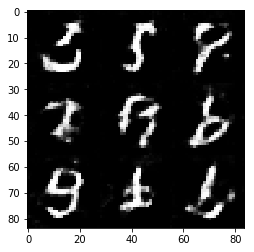

Epoch 2/2... Step   710... Discriminator Loss: 1.2594... Generator Loss: 1.0515
Epoch 2/2... Step   720... Discriminator Loss: 1.3598... Generator Loss: 0.6262
Epoch 2/2... Step   730... Discriminator Loss: 1.3675... Generator Loss: 0.5128
Epoch 2/2... Step   740... Discriminator Loss: 1.3009... Generator Loss: 0.8570
Epoch 2/2... Step   750... Discriminator Loss: 1.4511... Generator Loss: 0.4499
Epoch 2/2... Step   760... Discriminator Loss: 1.2273... Generator Loss: 0.6682
Epoch 2/2... Step   770... Discriminator Loss: 1.1776... Generator Loss: 1.0237
Epoch 2/2... Step   780... Discriminator Loss: 1.3808... Generator Loss: 1.2672
Epoch 2/2... Step   790... Discriminator Loss: 1.1967... Generator Loss: 1.1836
Epoch 2/2... Step   800... Discriminator Loss: 1.3846... Generator Loss: 0.6259


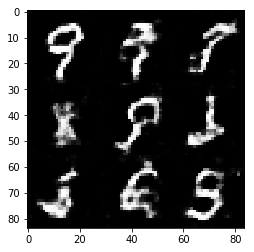

Epoch 2/2... Step   810... Discriminator Loss: 1.1740... Generator Loss: 1.2837
Epoch 2/2... Step   820... Discriminator Loss: 1.1723... Generator Loss: 1.0212
Epoch 2/2... Step   830... Discriminator Loss: 1.1823... Generator Loss: 0.9061
Epoch 2/2... Step   840... Discriminator Loss: 1.2191... Generator Loss: 1.2556
Epoch 2/2... Step   850... Discriminator Loss: 1.3157... Generator Loss: 1.2713
Epoch 2/2... Step   860... Discriminator Loss: 1.1626... Generator Loss: 1.0463
Epoch 2/2... Step   870... Discriminator Loss: 1.2197... Generator Loss: 0.7094
Epoch 2/2... Step   880... Discriminator Loss: 1.1139... Generator Loss: 0.8232
Epoch 2/2... Step   890... Discriminator Loss: 1.1783... Generator Loss: 0.7901
Epoch 2/2... Step   900... Discriminator Loss: 1.4598... Generator Loss: 1.5980


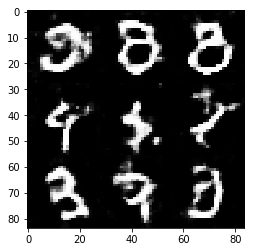

Epoch 2/2... Step   910... Discriminator Loss: 1.2324... Generator Loss: 1.1380
Epoch 2/2... Step   920... Discriminator Loss: 1.1701... Generator Loss: 0.9975
Epoch 2/2... Step   930... Discriminator Loss: 1.3133... Generator Loss: 0.6067
Epoch 2/2... Step   940... Discriminator Loss: 1.2664... Generator Loss: 0.7624
Epoch 2/2... Step   950... Discriminator Loss: 1.0471... Generator Loss: 1.0658
Epoch 2/2... Step   960... Discriminator Loss: 1.2738... Generator Loss: 1.2667
Epoch 2/2... Step   970... Discriminator Loss: 1.1694... Generator Loss: 0.9655
Epoch 2/2... Step   980... Discriminator Loss: 1.2812... Generator Loss: 0.6103
Epoch 2/2... Step   990... Discriminator Loss: 1.2665... Generator Loss: 0.6241
Epoch 2/2... Step  1000... Discriminator Loss: 1.7513... Generator Loss: 0.3157


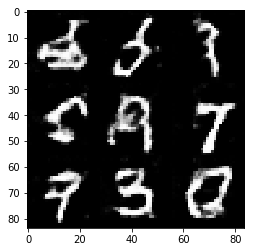

Epoch 2/2... Step  1010... Discriminator Loss: 1.2932... Generator Loss: 0.5880
Epoch 2/2... Step  1020... Discriminator Loss: 1.2697... Generator Loss: 0.6655
Epoch 2/2... Step  1030... Discriminator Loss: 1.1750... Generator Loss: 0.8807
Epoch 2/2... Step  1040... Discriminator Loss: 1.2974... Generator Loss: 1.3720
Epoch 2/2... Step  1050... Discriminator Loss: 1.2403... Generator Loss: 1.1229
Epoch 2/2... Step  1060... Discriminator Loss: 1.2410... Generator Loss: 0.8140
Epoch 2/2... Step  1070... Discriminator Loss: 1.1086... Generator Loss: 1.0728
Epoch 2/2... Step  1080... Discriminator Loss: 1.2811... Generator Loss: 1.7988
Epoch 2/2... Step  1090... Discriminator Loss: 1.2231... Generator Loss: 1.1062
Epoch 2/2... Step  1100... Discriminator Loss: 1.2393... Generator Loss: 1.2930


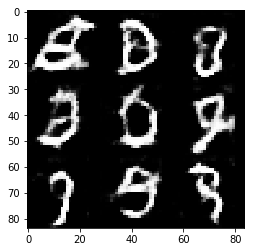

Epoch 2/2... Step  1110... Discriminator Loss: 1.1899... Generator Loss: 1.4920
Epoch 2/2... Step  1120... Discriminator Loss: 1.1336... Generator Loss: 1.0612
Epoch 2/2... Step  1130... Discriminator Loss: 1.1794... Generator Loss: 0.6988
Epoch 2/2... Step  1140... Discriminator Loss: 1.2689... Generator Loss: 0.5986
Epoch 2/2... Step  1150... Discriminator Loss: 1.4133... Generator Loss: 1.7500
Epoch 2/2... Step  1160... Discriminator Loss: 1.0587... Generator Loss: 1.3134
Epoch 2/2... Step  1170... Discriminator Loss: 1.1631... Generator Loss: 1.1506
Epoch 2/2... Step  1180... Discriminator Loss: 1.0464... Generator Loss: 1.3794
Epoch 2/2... Step  1190... Discriminator Loss: 1.2606... Generator Loss: 0.5914
Epoch 2/2... Step  1200... Discriminator Loss: 1.1172... Generator Loss: 0.7748


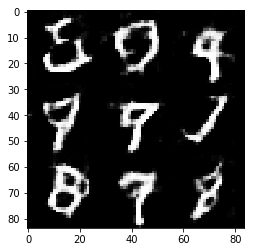

In [41]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step    10... Discriminator Loss: 3.8932... Generator Loss: 0.0563
Epoch 1/1... Step    20... Discriminator Loss: 2.7204... Generator Loss: 0.1938
Epoch 1/1... Step    30... Discriminator Loss: 1.9722... Generator Loss: 0.4514
Epoch 1/1... Step    40... Discriminator Loss: 1.6352... Generator Loss: 0.5518
Epoch 1/1... Step    50... Discriminator Loss: 1.7051... Generator Loss: 0.5445
Epoch 1/1... Step    60... Discriminator Loss: 1.4660... Generator Loss: 0.6578
Epoch 1/1... Step    70... Discriminator Loss: 1.3910... Generator Loss: 0.7015
Epoch 1/1... Step    80... Discriminator Loss: 1.1848... Generator Loss: 1.0336
Epoch 1/1... Step    90... Discriminator Loss: 1.2402... Generator Loss: 0.7350
Epoch 1/1... Step   100... Discriminator Loss: 1.2494... Generator Loss: 0.6977


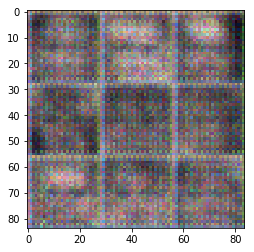

Epoch 1/1... Step   110... Discriminator Loss: 1.0208... Generator Loss: 0.9464
Epoch 1/1... Step   120... Discriminator Loss: 1.2501... Generator Loss: 2.1923
Epoch 1/1... Step   130... Discriminator Loss: 0.7735... Generator Loss: 1.9893
Epoch 1/1... Step   140... Discriminator Loss: 1.1178... Generator Loss: 2.8017
Epoch 1/1... Step   150... Discriminator Loss: 1.4208... Generator Loss: 0.4923
Epoch 1/1... Step   160... Discriminator Loss: 0.7081... Generator Loss: 2.9217
Epoch 1/1... Step   170... Discriminator Loss: 1.2427... Generator Loss: 2.7950
Epoch 1/1... Step   180... Discriminator Loss: 1.2378... Generator Loss: 0.7109
Epoch 1/1... Step   190... Discriminator Loss: 1.2644... Generator Loss: 0.7426
Epoch 1/1... Step   200... Discriminator Loss: 1.3502... Generator Loss: 0.5646


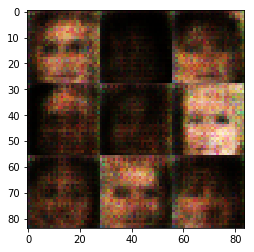

Epoch 1/1... Step   210... Discriminator Loss: 1.0597... Generator Loss: 2.9463
Epoch 1/1... Step   220... Discriminator Loss: 1.5982... Generator Loss: 1.1732
Epoch 1/1... Step   230... Discriminator Loss: 0.7451... Generator Loss: 2.9434
Epoch 1/1... Step   240... Discriminator Loss: 1.2060... Generator Loss: 0.8252
Epoch 1/1... Step   250... Discriminator Loss: 0.9282... Generator Loss: 1.2823
Epoch 1/1... Step   260... Discriminator Loss: 1.3314... Generator Loss: 0.5813
Epoch 1/1... Step   270... Discriminator Loss: 1.1097... Generator Loss: 0.9708
Epoch 1/1... Step   280... Discriminator Loss: 0.9288... Generator Loss: 2.0804
Epoch 1/1... Step   290... Discriminator Loss: 1.5867... Generator Loss: 0.4383
Epoch 1/1... Step   300... Discriminator Loss: 1.7458... Generator Loss: 0.3451


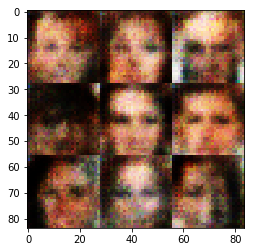

Epoch 1/1... Step   310... Discriminator Loss: 0.8417... Generator Loss: 1.2472
Epoch 1/1... Step   320... Discriminator Loss: 1.0095... Generator Loss: 2.8706
Epoch 1/1... Step   330... Discriminator Loss: 1.2480... Generator Loss: 0.6058
Epoch 1/1... Step   340... Discriminator Loss: 1.1655... Generator Loss: 0.8519
Epoch 1/1... Step   350... Discriminator Loss: 1.4608... Generator Loss: 1.4412
Epoch 1/1... Step   360... Discriminator Loss: 1.1337... Generator Loss: 2.5202
Epoch 1/1... Step   370... Discriminator Loss: 1.8810... Generator Loss: 0.2807
Epoch 1/1... Step   380... Discriminator Loss: 1.8250... Generator Loss: 0.3081
Epoch 1/1... Step   390... Discriminator Loss: 0.7415... Generator Loss: 1.7645
Epoch 1/1... Step   400... Discriminator Loss: 1.8146... Generator Loss: 0.2955


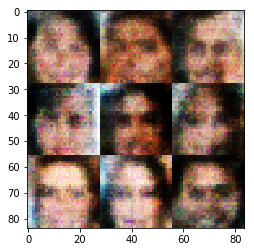

Epoch 1/1... Step   410... Discriminator Loss: 1.7154... Generator Loss: 0.3451
Epoch 1/1... Step   420... Discriminator Loss: 1.3265... Generator Loss: 0.5380
Epoch 1/1... Step   430... Discriminator Loss: 0.4870... Generator Loss: 3.4944
Epoch 1/1... Step   440... Discriminator Loss: 0.7756... Generator Loss: 1.6577
Epoch 1/1... Step   450... Discriminator Loss: 1.7488... Generator Loss: 0.3215
Epoch 1/1... Step   460... Discriminator Loss: 1.9767... Generator Loss: 0.2436
Epoch 1/1... Step   470... Discriminator Loss: 0.8299... Generator Loss: 1.5406
Epoch 1/1... Step   480... Discriminator Loss: 1.3978... Generator Loss: 1.0076
Epoch 1/1... Step   490... Discriminator Loss: 0.6918... Generator Loss: 1.9262
Epoch 1/1... Step   500... Discriminator Loss: 1.1951... Generator Loss: 0.7257


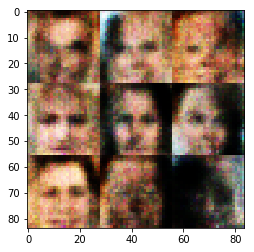

Epoch 1/1... Step   510... Discriminator Loss: 0.5089... Generator Loss: 3.9916
Epoch 1/1... Step   520... Discriminator Loss: 1.2395... Generator Loss: 0.5972
Epoch 1/1... Step   530... Discriminator Loss: 1.2783... Generator Loss: 2.6725
Epoch 1/1... Step   540... Discriminator Loss: 0.7911... Generator Loss: 1.5165
Epoch 1/1... Step   550... Discriminator Loss: 1.4551... Generator Loss: 0.4612
Epoch 1/1... Step   560... Discriminator Loss: 1.4267... Generator Loss: 0.4807
Epoch 1/1... Step   570... Discriminator Loss: 0.4580... Generator Loss: 3.8883
Epoch 1/1... Step   580... Discriminator Loss: 0.5866... Generator Loss: 2.6219
Epoch 1/1... Step   590... Discriminator Loss: 0.7630... Generator Loss: 2.4436
Epoch 1/1... Step   600... Discriminator Loss: 0.7315... Generator Loss: 1.6150


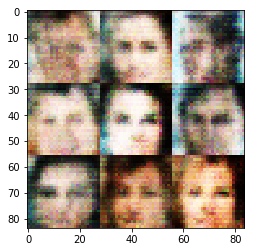

Epoch 1/1... Step   610... Discriminator Loss: 0.8762... Generator Loss: 3.6136
Epoch 1/1... Step   620... Discriminator Loss: 0.4107... Generator Loss: 4.2041
Epoch 1/1... Step   630... Discriminator Loss: 0.5130... Generator Loss: 2.5269
Epoch 1/1... Step   640... Discriminator Loss: 2.1288... Generator Loss: 0.2294
Epoch 1/1... Step   650... Discriminator Loss: 1.1555... Generator Loss: 0.7655
Epoch 1/1... Step   660... Discriminator Loss: 0.8515... Generator Loss: 2.9849
Epoch 1/1... Step   670... Discriminator Loss: 1.2092... Generator Loss: 0.6129
Epoch 1/1... Step   680... Discriminator Loss: 0.8275... Generator Loss: 2.5364
Epoch 1/1... Step   690... Discriminator Loss: 2.0903... Generator Loss: 0.2169
Epoch 1/1... Step   700... Discriminator Loss: 0.7161... Generator Loss: 4.1878


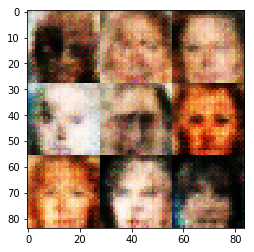

Epoch 1/1... Step   710... Discriminator Loss: 1.0504... Generator Loss: 2.2567
Epoch 1/1... Step   720... Discriminator Loss: 0.6136... Generator Loss: 2.2822
Epoch 1/1... Step   730... Discriminator Loss: 0.8487... Generator Loss: 2.0729
Epoch 1/1... Step   740... Discriminator Loss: 1.8891... Generator Loss: 0.2640
Epoch 1/1... Step   750... Discriminator Loss: 1.0159... Generator Loss: 0.9075
Epoch 1/1... Step   760... Discriminator Loss: 1.5140... Generator Loss: 0.4598
Epoch 1/1... Step   770... Discriminator Loss: 0.4877... Generator Loss: 3.0524
Epoch 1/1... Step   780... Discriminator Loss: 1.6862... Generator Loss: 0.3612
Epoch 1/1... Step   790... Discriminator Loss: 0.9759... Generator Loss: 2.1160
Epoch 1/1... Step   800... Discriminator Loss: 0.7320... Generator Loss: 1.6947


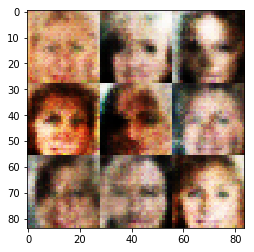

Epoch 1/1... Step   810... Discriminator Loss: 0.5577... Generator Loss: 4.6477
Epoch 1/1... Step   820... Discriminator Loss: 0.6073... Generator Loss: 1.9117
Epoch 1/1... Step   830... Discriminator Loss: 2.1037... Generator Loss: 0.2143
Epoch 1/1... Step   840... Discriminator Loss: 0.5212... Generator Loss: 2.8194
Epoch 1/1... Step   850... Discriminator Loss: 0.7789... Generator Loss: 1.2795
Epoch 1/1... Step   860... Discriminator Loss: 1.1887... Generator Loss: 0.6028
Epoch 1/1... Step   870... Discriminator Loss: 1.0483... Generator Loss: 0.8740
Epoch 1/1... Step   880... Discriminator Loss: 0.8454... Generator Loss: 1.2741
Epoch 1/1... Step   890... Discriminator Loss: 0.7738... Generator Loss: 1.2965
Epoch 1/1... Step   900... Discriminator Loss: 0.8258... Generator Loss: 1.5789


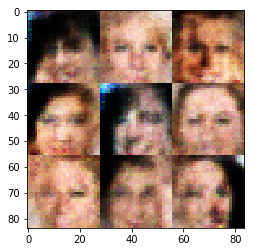

Epoch 1/1... Step   910... Discriminator Loss: 0.7443... Generator Loss: 1.6900
Epoch 1/1... Step   920... Discriminator Loss: 0.6247... Generator Loss: 2.1388
Epoch 1/1... Step   930... Discriminator Loss: 1.0480... Generator Loss: 0.7932
Epoch 1/1... Step   940... Discriminator Loss: 0.6078... Generator Loss: 2.8604
Epoch 1/1... Step   950... Discriminator Loss: 1.5900... Generator Loss: 0.4820
Epoch 1/1... Step   960... Discriminator Loss: 0.8524... Generator Loss: 1.1444
Epoch 1/1... Step   970... Discriminator Loss: 1.1085... Generator Loss: 0.7771
Epoch 1/1... Step   980... Discriminator Loss: 0.7933... Generator Loss: 3.0282
Epoch 1/1... Step   990... Discriminator Loss: 0.5673... Generator Loss: 2.1809
Epoch 1/1... Step  1000... Discriminator Loss: 1.0116... Generator Loss: 0.8812


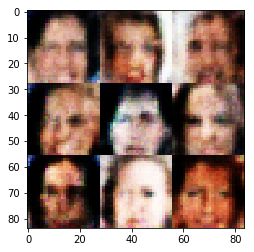

Epoch 1/1... Step  1010... Discriminator Loss: 0.8675... Generator Loss: 1.7522
Epoch 1/1... Step  1020... Discriminator Loss: 0.7154... Generator Loss: 2.3824
Epoch 1/1... Step  1030... Discriminator Loss: 1.4352... Generator Loss: 0.4879
Epoch 1/1... Step  1040... Discriminator Loss: 0.8367... Generator Loss: 2.0995
Epoch 1/1... Step  1050... Discriminator Loss: 1.0452... Generator Loss: 1.0486
Epoch 1/1... Step  1060... Discriminator Loss: 0.7744... Generator Loss: 3.4969
Epoch 1/1... Step  1070... Discriminator Loss: 0.7437... Generator Loss: 1.3501
Epoch 1/1... Step  1080... Discriminator Loss: 1.2342... Generator Loss: 0.6825
Epoch 1/1... Step  1090... Discriminator Loss: 1.9224... Generator Loss: 0.5766
Epoch 1/1... Step  1100... Discriminator Loss: 0.7278... Generator Loss: 2.5110


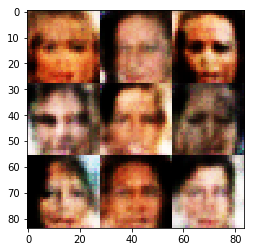

Epoch 1/1... Step  1110... Discriminator Loss: 1.0524... Generator Loss: 0.8272
Epoch 1/1... Step  1120... Discriminator Loss: 1.2410... Generator Loss: 0.9104
Epoch 1/1... Step  1130... Discriminator Loss: 0.6642... Generator Loss: 2.1276
Epoch 1/1... Step  1140... Discriminator Loss: 1.1715... Generator Loss: 1.7312
Epoch 1/1... Step  1150... Discriminator Loss: 0.8060... Generator Loss: 1.5390
Epoch 1/1... Step  1160... Discriminator Loss: 1.4482... Generator Loss: 0.4566
Epoch 1/1... Step  1170... Discriminator Loss: 1.1591... Generator Loss: 0.7246
Epoch 1/1... Step  1180... Discriminator Loss: 0.8801... Generator Loss: 1.2701
Epoch 1/1... Step  1190... Discriminator Loss: 1.8193... Generator Loss: 0.2940
Epoch 1/1... Step  1200... Discriminator Loss: 1.3139... Generator Loss: 0.7273


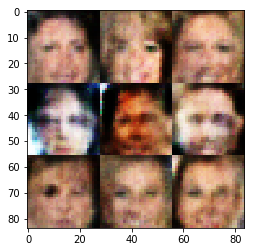

Epoch 1/1... Step  1210... Discriminator Loss: 1.3467... Generator Loss: 0.8057
Epoch 1/1... Step  1220... Discriminator Loss: 1.2619... Generator Loss: 1.4256
Epoch 1/1... Step  1230... Discriminator Loss: 1.0640... Generator Loss: 1.5654
Epoch 1/1... Step  1240... Discriminator Loss: 0.8597... Generator Loss: 1.8624
Epoch 1/1... Step  1250... Discriminator Loss: 0.9576... Generator Loss: 1.1694
Epoch 1/1... Step  1260... Discriminator Loss: 0.6726... Generator Loss: 2.5433
Epoch 1/1... Step  1270... Discriminator Loss: 0.8997... Generator Loss: 1.7257
Epoch 1/1... Step  1280... Discriminator Loss: 0.6539... Generator Loss: 1.8129
Epoch 1/1... Step  1290... Discriminator Loss: 0.8958... Generator Loss: 1.4456
Epoch 1/1... Step  1300... Discriminator Loss: 3.3743... Generator Loss: 1.2627


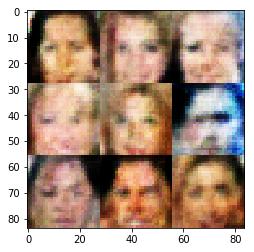

Epoch 1/1... Step  1310... Discriminator Loss: 1.3438... Generator Loss: 0.6240
Epoch 1/1... Step  1320... Discriminator Loss: 1.0051... Generator Loss: 1.3992
Epoch 1/1... Step  1330... Discriminator Loss: 0.8914... Generator Loss: 1.4704
Epoch 1/1... Step  1340... Discriminator Loss: 0.9543... Generator Loss: 0.9849
Epoch 1/1... Step  1350... Discriminator Loss: 1.6506... Generator Loss: 0.5177
Epoch 1/1... Step  1360... Discriminator Loss: 0.8428... Generator Loss: 1.4551
Epoch 1/1... Step  1370... Discriminator Loss: 1.5124... Generator Loss: 0.4238
Epoch 1/1... Step  1380... Discriminator Loss: 1.1229... Generator Loss: 0.8061
Epoch 1/1... Step  1390... Discriminator Loss: 0.9857... Generator Loss: 1.6965
Epoch 1/1... Step  1400... Discriminator Loss: 0.9514... Generator Loss: 1.3792


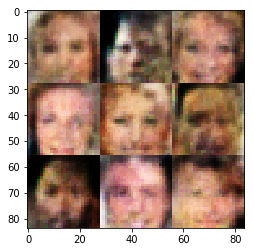

Epoch 1/1... Step  1410... Discriminator Loss: 0.9062... Generator Loss: 1.6950
Epoch 1/1... Step  1420... Discriminator Loss: 0.9404... Generator Loss: 1.3083
Epoch 1/1... Step  1430... Discriminator Loss: 0.7537... Generator Loss: 2.6786
Epoch 1/1... Step  1440... Discriminator Loss: 1.4425... Generator Loss: 0.4769
Epoch 1/1... Step  1450... Discriminator Loss: 1.0483... Generator Loss: 1.4075
Epoch 1/1... Step  1460... Discriminator Loss: 0.9351... Generator Loss: 1.2745
Epoch 1/1... Step  1470... Discriminator Loss: 0.9900... Generator Loss: 1.0629
Epoch 1/1... Step  1480... Discriminator Loss: 1.1073... Generator Loss: 0.8827
Epoch 1/1... Step  1490... Discriminator Loss: 0.8163... Generator Loss: 1.2139
Epoch 1/1... Step  1500... Discriminator Loss: 0.7527... Generator Loss: 2.3056


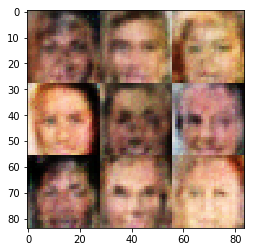

Epoch 1/1... Step  1510... Discriminator Loss: 1.2350... Generator Loss: 0.8597
Epoch 1/1... Step  1520... Discriminator Loss: 1.5739... Generator Loss: 0.5736
Epoch 1/1... Step  1530... Discriminator Loss: 0.8618... Generator Loss: 1.3298
Epoch 1/1... Step  1540... Discriminator Loss: 0.8436... Generator Loss: 1.5625
Epoch 1/1... Step  1550... Discriminator Loss: 1.3328... Generator Loss: 1.2166
Epoch 1/1... Step  1560... Discriminator Loss: 1.1079... Generator Loss: 0.8999
Epoch 1/1... Step  1570... Discriminator Loss: 2.0562... Generator Loss: 1.0788
Epoch 1/1... Step  1580... Discriminator Loss: 1.3315... Generator Loss: 0.6417
Epoch 1/1... Step  1590... Discriminator Loss: 0.8410... Generator Loss: 1.8684
Epoch 1/1... Step  1600... Discriminator Loss: 1.0699... Generator Loss: 3.0206


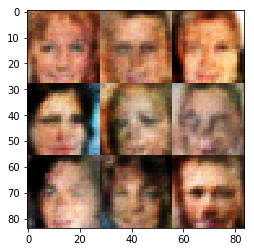

Epoch 1/1... Step  1610... Discriminator Loss: 0.7913... Generator Loss: 1.9737
Epoch 1/1... Step  1620... Discriminator Loss: 0.9139... Generator Loss: 1.5543
Epoch 1/1... Step  1630... Discriminator Loss: 0.7040... Generator Loss: 2.0235
Epoch 1/1... Step  1640... Discriminator Loss: 1.0331... Generator Loss: 0.9070
Epoch 1/1... Step  1650... Discriminator Loss: 0.7998... Generator Loss: 1.7786
Epoch 1/1... Step  1660... Discriminator Loss: 0.8619... Generator Loss: 1.9322
Epoch 1/1... Step  1670... Discriminator Loss: 1.2721... Generator Loss: 0.6434
Epoch 1/1... Step  1680... Discriminator Loss: 0.7936... Generator Loss: 2.3052
Epoch 1/1... Step  1690... Discriminator Loss: 1.0494... Generator Loss: 1.2104
Epoch 1/1... Step  1700... Discriminator Loss: 1.3222... Generator Loss: 0.5849


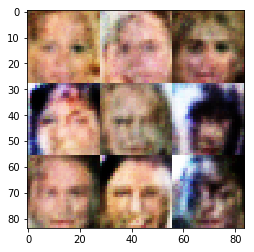

Epoch 1/1... Step  1710... Discriminator Loss: 1.1205... Generator Loss: 0.9539
Epoch 1/1... Step  1720... Discriminator Loss: 1.0465... Generator Loss: 1.0975
Epoch 1/1... Step  1730... Discriminator Loss: 1.2022... Generator Loss: 0.7574
Epoch 1/1... Step  1740... Discriminator Loss: 1.0633... Generator Loss: 2.0011
Epoch 1/1... Step  1750... Discriminator Loss: 1.5763... Generator Loss: 0.5218
Epoch 1/1... Step  1760... Discriminator Loss: 1.0745... Generator Loss: 0.9604
Epoch 1/1... Step  1770... Discriminator Loss: 1.1315... Generator Loss: 1.0767
Epoch 1/1... Step  1780... Discriminator Loss: 0.6448... Generator Loss: 2.1835
Epoch 1/1... Step  1790... Discriminator Loss: 1.0564... Generator Loss: 0.8372
Epoch 1/1... Step  1800... Discriminator Loss: 0.8365... Generator Loss: 1.8617


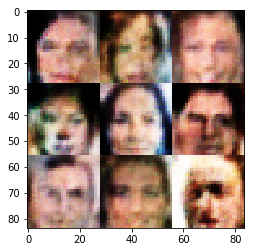

Epoch 1/1... Step  1810... Discriminator Loss: 1.2590... Generator Loss: 1.0331
Epoch 1/1... Step  1820... Discriminator Loss: 0.9785... Generator Loss: 1.6886
Epoch 1/1... Step  1830... Discriminator Loss: 1.7281... Generator Loss: 1.1375
Epoch 1/1... Step  1840... Discriminator Loss: 0.8219... Generator Loss: 2.3097
Epoch 1/1... Step  1850... Discriminator Loss: 1.0312... Generator Loss: 1.9935
Epoch 1/1... Step  1860... Discriminator Loss: 0.9344... Generator Loss: 1.8101
Epoch 1/1... Step  1870... Discriminator Loss: 1.7949... Generator Loss: 0.9120
Epoch 1/1... Step  1880... Discriminator Loss: 1.1756... Generator Loss: 0.9102
Epoch 1/1... Step  1890... Discriminator Loss: 0.8213... Generator Loss: 1.3331
Epoch 1/1... Step  1900... Discriminator Loss: 0.8190... Generator Loss: 1.9831


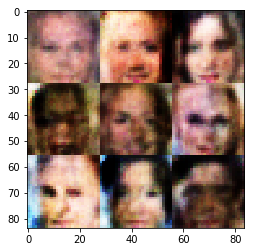

Epoch 1/1... Step  1910... Discriminator Loss: 0.9681... Generator Loss: 1.6381
Epoch 1/1... Step  1920... Discriminator Loss: 0.7563... Generator Loss: 1.7378
Epoch 1/1... Step  1930... Discriminator Loss: 0.8969... Generator Loss: 1.1790
Epoch 1/1... Step  1940... Discriminator Loss: 0.8918... Generator Loss: 1.3597
Epoch 1/1... Step  1950... Discriminator Loss: 1.1913... Generator Loss: 0.6599
Epoch 1/1... Step  1960... Discriminator Loss: 1.0137... Generator Loss: 1.0128
Epoch 1/1... Step  1970... Discriminator Loss: 0.9980... Generator Loss: 1.0104
Epoch 1/1... Step  1980... Discriminator Loss: 0.8682... Generator Loss: 2.5498
Epoch 1/1... Step  1990... Discriminator Loss: 0.8618... Generator Loss: 1.2624
Epoch 1/1... Step  2000... Discriminator Loss: 0.8119... Generator Loss: 1.5076


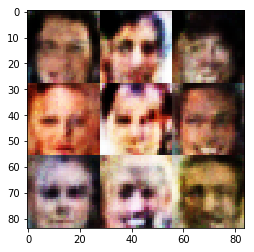

Epoch 1/1... Step  2010... Discriminator Loss: 0.7204... Generator Loss: 1.7071
Epoch 1/1... Step  2020... Discriminator Loss: 1.4410... Generator Loss: 0.8116


In [12]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.